In [1]:
import numpy as np
import control
import matplotlib.pyplot as plt

from scipy.integrate import odeint

# Why to bother about discrete-time controllers?

In the first class of our series of notebooks, we will have a look in the implications of moving from continuos-time to discrete-time controllers.

As everything is better understood with examples, let's start by describing our hypothetical system:

\begin{equation*}

G(s) = \frac{1}{s\cdot(s+2)}

\end{equation*}

Which can be defined in our control library as:


In [2]:
num = [1]
den = [1,2,0]
G = control.TransferFunction(num, den)

## Proportional controller design

As a quick reminder on the basics of control theory, let's first design a proportional controller (negative feedback system) such that we have a damping ratio of $\xi=0.7$.

A good way for doing so, is building the root locus of our system and looking for its intersection with the corresping damping ratio line.

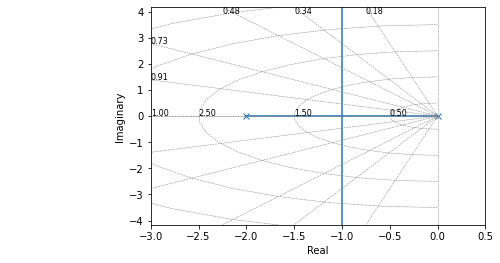

In [3]:
_ = control.root_locus(G,
                       xlim = (-3,0.5),
                       Plot=True,
                       PrintGain=False,
                       grid=True)

Since we have $\xi=0.7$, $\theta\approx\pi/4$, meaning that the intersection we are interested in is around $s=1\pm j$.

By using the gain condition:

$$  ||G(s) \cdot H(s) || = 1 $$
$$  || \frac{K_p}{s(s+2)} || = 1 $$

$$ K_p = ||1+j||  \cdot ||-1+j+2|| = 2 $$

## Continuous-ish simulation

Before analyzing anything in the discrete-time domain, we may want to know how the controlled system would respond if we had a continuous-time controller. 

In theory, it is impossible to do such a simulation, but if we evaluate it with a really fast sampling rate (we will discuss it deeper in a later class) we may get something close enough from what we want. 

Hence, we should have an intuition of what we could consider "close enough" from continuous-time. Altough it is quite subjective, we will be considering "constinuous enough" as an analysis running 1000 faster than the fastest dynamic response (e.g. dominant pole) of the system.

Neglecting the pole at the origin (just to keep things simple), we will take as a reference the time constant of the first order system $\frac{1}{s+2}$, $\tau = 0.5$. It means that we later we will use $f_{sampling}=2000~Hz$ for simulating the continuous system.


### Control library plot

A first way of doing this analysis is by means of the control library:

Text(0, 0.5, 'y')

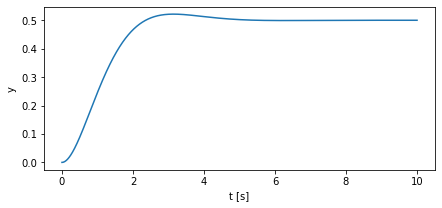

In [4]:
# our controller parameters
Kp = 2

f_sample = 2000
t0, tf = 0, 10
N_samples = f_sample*(tf-t0)
t = np.linspace(t0, tf, N_samples)


# build the negative feedback transfere function
G_feedback = control.feedback(G,Kp, sign=-1)

# compute the step response
t, y = control.step_response(G_feedback, T=t)

plt.figure(figsize=(7,3))
plt.plot(t, y)
plt.xlabel("t [s]")
plt.ylabel("y")

So far everything seems to work smoothly, but here we have a rather unrealistic scenario for most of current digitally-controlled systems.

What we have done here was to incorporate the controller dynamic inside the transfer function of the controlled system. The issue of doing so the way we did is that there is no disassociation between the discrete integration of the model dynamics (which should be as close to continuous as possible) and the dynamic of the controller, which should in reality would be executed at a slower rate. 


### Separating system and controller dynamics

In order to separate those two dynamics in our example, we will compute and merge the system's model and the controller response manually.

For doing so we will use an integrator that uses state space instead of transfer functions, se we will convert our model to this representation:


$$ G(s) = \frac{1}{s \cdot (s+2)} $$

Assuming that we have null initial conditions, one may rewrite it in a differential form:

$$ \ddot{x} + 2\dot{x} = 0 $$

Or as space state equation:

$$ \dot{X}(t) = A \cdot X(t) + B \cdot U(t)$$

Being:


\begin{equation*}
    X(t) =
    \begin{bmatrix}
        x(t) \\
        \dot{x}(t)
    \end{bmatrix} ;
    A(t) = 
    \begin{bmatrix}
        0 & 1 \\
        0 & -2
    \end{bmatrix};
\end{equation*}

\begin{equation*}
    B\cdot U(t) = 
    \begin{bmatrix}
        0 \\
        0
    \end{bmatrix}
\end{equation*}

If we introduce a proportional control $u(t) = K_p\cdot \epsilon$, the differential equation becomes:

$$ \ddot{x} + 2\dot{x} = u(t) $$

Changing just one component of the state space:

\begin{equation*}
    B\cdot U(t) = 
    \begin{bmatrix}
        0 \\
        u(t)
    \end{bmatrix}
\end{equation*}

In order to introduce the expression of $\dot{X}$ into our numerical integrator, we will create function for representing it:

In [5]:
def dXdt (X, t, U):
    X_d =np.array([X[1],
                   -2*X[1]
                   ]) + U
    return X_d

We finally we can write a function for the time simulation itself:

In [6]:
def timeSimulator(X_0, dXdt, X_ref=1,
                  f_simulator=1000, f_control=50,
                  t_start=0, t_end = 10,
                  Kp=0, Kd=0, Ki=0):

    # build time
    t = np.linspace(t_start, t_end, (t_end-t_start)*f_simulator)
    dt = t[1] - t[0] 

    # time steps between two control actions happen
    steps_to_control = int(f_simulator / f_control)

    # state variables
    X = np.zeros((len(X_0), len(t)))
    X[:,0] = X_0

    # control comand:
    U = np.zeros((2, len(t) ))
    err_int = 0                 # integral error
    err_prev = 0                # error at previous step measured by the controller

    # loop for the physical model simulator
    for i in range(1, len(t)):

        # at every steps_to_control, the controller acts and updates its output
        # because of initialization issues, use _%_=1
        if (i % steps_to_control == 1):

            # measure error
            err = X_ref - X[0, i-1]

            #derivative error
            if (i!=0):
                err_der = (X[0, i-1] + X[0, i - steps_to_control]) / (2/f_control)
            else:
                err_der = (X[0, i-1] + X[0, 0]) / (2/f_control)

            # integral error
            err_int += (err / f_control)

            # update controller output
            U[1, i:i+steps_to_control] = Kp * err + Kd * err_der + Ki * err_int

        # integrate the model over one time step
        X[:,i] = odeint(dXdt,               # model descriptor
                        X[:, i-1],          # previous state
                        [t[i-1],  t[i]],    # time interval
                        args=(U[:,i],)      # extra arguments to pass to function, besides previous step and time interval
                    ) [1,:]

    return (t, X, U)

Now that we have built the model, the controller and the simulator, we can in fact run the simulation of a discrete time controller using:

$$ f_{sim} = 2000~Hz $$
$$ f_{control} = 100~Hz $$


In [7]:
X_0 = np.array([0,0])
X_ref = 1

Kp = 2

f_simulator = 1000
f_control = 100

t,X_cont,U_cont = timeSimulator(X_0, dXdt, X_ref, 
                      f_simulator=f_simulator, f_control=f_control,
                      Kp=Kp)

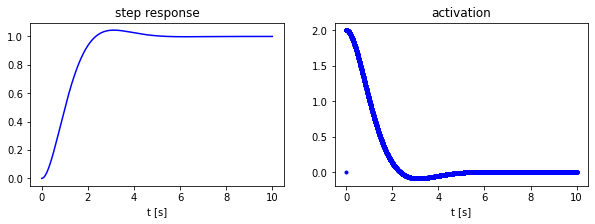

In [8]:
plt.figure(figsize = (10,3))

plt.subplot(1,2,1)
plt.plot(t, X_cont[0,:], "b-")
plt.title("step response")
plt.xlabel("t [s]")

plt.subplot(1,2,2)
plt.plot(t, U_cont[1,:], "b.")
plt.title("activation")
plt.xlabel("t [s]")

plt.show()

Take note that this controller works almost as a continuous one, since we have the sampling frequence much higher than the natural frequence (or, in the case of first order system, than the inverse of the time constant of its non-zero pole) of the system:

$$ f_{control} = 100 >> f_n = \frac{1}{\tau} = 2 $$


## Discrete-time controller

Now, lets see what happens if we take a "low" refresh rate for the controller (i.e. $f_{control}=1$), and compare it to response of the controller previously seen:

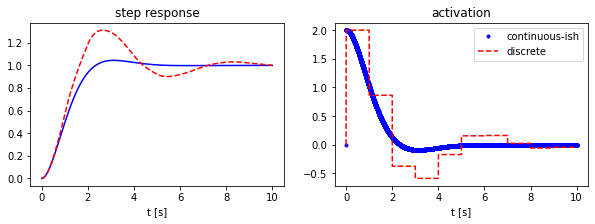

In [9]:
f_control = 1

_,X_disc,U_disc = timeSimulator(X_0, dXdt, X_ref, 
                      f_simulator=f_simulator, f_control=f_control,
                      Kp=Kp)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(t, X_cont[0,:], "b-")
plt.plot(t, X_disc[0,:], "r--")
plt.title("step response")
plt.xlabel("t [s]")

plt.subplot(1,2,2)
plt.plot(t, U_cont[1,:], "b.")
plt.plot(t, U_disc[1,:], "r--")
plt.title("activation")
plt.xlabel("t [s]")

plt.legend(["continuous-ish", "discrete"])

plt.show()

From this simulation we can see that the system with a slower controller oscilates much more than the previous one. 

In order to understand the reason why, one may have a look at the plot at the right-hand side. It shows the activation of our system, or, said differently, the input the controller give to (i.e. voltage, current, force, etc.) it based on the target output and on the last measured state.

From our activation plot, one may see the main difference between continuous-time and discrete-time controllers. Basically, what the latter does is to sample the state of the continuous sytem at time $t_i$, compute the input to be appied at the system at time $t_i + \delta t$ (where $\delta t$ is the usually negligible time between reading the states and applying the step input) and hold it until the next controller sample at time $t_{i+1}$. That is why we have this stair-like activation. Moreover, this "holding" behaviour is an example of what is called in signal processing the **zero-order hold**.

Intuitively, the effect of this holding is to delay the response of the controller with respect to the update of the system. This is the reason why our discrete representation of a controller presents much more oscilation than the continous-ish one.

## Minimum continuous-ish controller

A rule of thumb for obtaining the minimum controller sampling rate for considering the closed loop system continous is taking 

$$f_{control} = 50 \cdot bandwidth$$

In order to obtain the bandwidth of our closed system, let's plot the bode diagram and look for $|G_{closed}(\omega)| = -3~dB$.

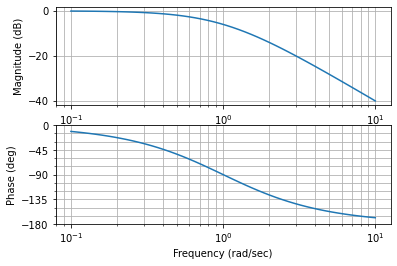

In [10]:
mag, phase, omega = control.bode(control.feedback(G), dB=True)

In [11]:
mag_dB = 20*np.log10(mag)

minVal  = np.amin(np.abs(mag_dB - (-3) ) )
bandwidth_index = np.where(np.abs(mag_dB - (-3) )== minVal)
bandwidth = omega[bandwidth_index[0]]

bandwidth_Hz = bandwidth/(2*np.pi)

print("The closed-loop bandwidth is: {:.3f} Hz".format(bandwidth_Hz[0]) )

print("The limit where we can consider our digital controller to act as a continuous one is: {:.3f} Hz".format(50*bandwidth_Hz[0]) )


The closed-loop bandwidth is: 0.104 Hz
The limit where we can consider our digital controller to act as a continuous one is: 5.213 Hz


Hence, according to our rule of thumb, the limit for considering the control loop as continuous is:
$$ f_{control} = 50 \cdot bandwidth =  5.21~Hz$$ 

## Effects of time discretization 

In order to have a better idea of the effects of moving to discrete-time controllers, let's simulate the system for multiple sampling frequencies:


testing for controller sampling rates:  [24.    12.     6.     3.     1.5    0.75   0.375]


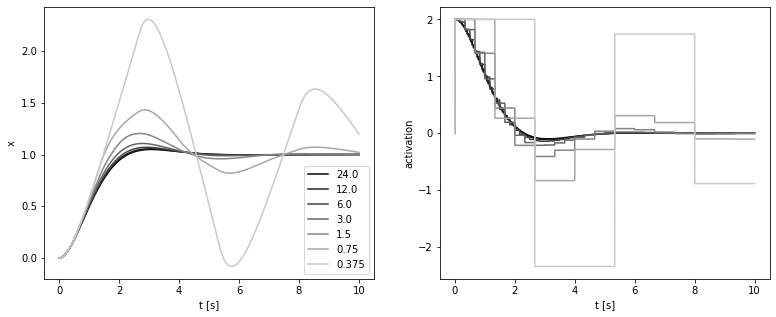

In [12]:
n_sims = 7
temp = 2**np.linspace(0,6,n_sims)
fs_control = 24 / temp

print("testing for controller sampling rates: ", fs_control)

plot_colors = np.linspace(0,200,n_sims)
plot_colors = np.transpose(np.tile(plot_colors, [3,1])).astype("int")

plt.figure(figsize=(13,5))

for i in range(0, n_sims):
    f_control = fs_control[i]
    color = plot_colors[i,:]

    t, X, U = timeSimulator(X_0, dXdt, X_ref, 
                                        f_simulator=f_simulator, f_control=f_control,
                                        Kp=Kp)
    plt.subplot(121)
    plt.plot(t,X[0,:],color=color/255)

    plt.subplot(122)
    plt.plot(t,U[1,:],color=color/255)

plt.subplot(121)
plt.ylabel("x")
plt.xlabel("t [s]")
plt.legend(fs_control)


plt.subplot(122)
plt.ylabel("activation")
_ = plt.xlabel("t [s]")

plt.show()

In the plot at the left it is observable that the digitalization of the controller in fact has a major impact in the performance of the system. As the controller's frequency reduces, the instability of the controlled variable increases significantly. Such behaviour can be attributed to the delay between the changing of the system'a state (simulated to be almost continous) and the update of the controller.

The activation, plotted at the right, shows a typical Zero-order hold acting in each of the frequencies, characteristic of traditional digital controllers. 

Besides that, one can see that for the three highest frequencies tested, we have a similiar overall response,  whereas the response starts to deteriorate more significantly from a sampling rate 3 Hz on. This is an indicates to us that the 50 times bandwidth rule for digital controllers do is reasonable.



## Conclusion and next steps

From this first lecture we have seen why we should care about the effects of controlling systems in discrete-time. Moreover, we have learned a rule of thumb that comes handy for helping us to decide whether or not to take the effects of time discretization in our controlled system.

If this is the case, we will need to use some tools that we will explore in the next lecture, beeing the most important of them the _Z transform_.